In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


# Project: Analysis on the WeRateDogs Twitter Archive

## Table of Contents
- Introduction
    - <a href = "#imports"> Notebook Imports </a>
    - <a href = "#constants"> Constants </a>
    - <a href = "#functions"> Function Definitions </a>
- Data Wrangling
    - <a href = "#gathering"> Data Gathering </a>
    - <a href = "#assessing"> Data Assessing </a>
    - <a href = "#cleaning"> Data Cleaning </a>
    - <a href = "#storing"> Data Storing </a>
- <a href = "#analysis"> Data Analysis and Visualization </a>
- <a href = "#conclusions"> Conclusions </a>

## Introduction

> WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. People may want to buy dogs that are humorous or otherwise. The goal of the project is to analyze and know the humour level of each breed of dog. Each dog is rated differently based on humour level with a common rating denominator of 10 but with _weird_ levels of rating numerator, some higher than 10, but that is all part of the fun of the [`@dog_rates`](https://twitter.com/dog_rates) twitter account. From the description of the project, some ratings in the `twitter-archive-enhanced.csv` were not accurately pulled from the `text` and thus revisiting had to be done.

> Only eight (8) quality issues and two (2) tidiness issues, at minimum, were to be identified and addressed due to the robustness of the data.

<a id='imports'></a>
### Notebook Imports

In [2]:
import pandas as pd  # For Data Manipulation
import numpy as np  # For Array Manipulation

import os  # For Local System Access
import requests  # For Web Access

import tweepy  # For Accessing Twitter's API
import json # For Manipulation of JSON Files

import re  # For Regular Expressions

import matplotlib.pyplot as matpy  # For Data Visualization
import seaborn as sb  # For Data Visualization
%matplotlib inline

<a id='constants'></a>
### Constants

In [3]:
IMAGE_URL = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
IMAGE_FILE = IMAGE_URL.split("/")[-1]
API_FILE = "twitter_json.txt"

API_KEY = input("Enter API key: ")
API_SECRET = input("Enter API secret: ")
ACCESS_TOKEN = input("Enter access token: ")
ACCESS_SECRET = input("Enter access secret: ")

Enter API key: 
Enter API secret: 
Enter access token: 
Enter access secret: 


<a id='functions'></a>
### Function Definitions

In [4]:
def summary(df):
    """
    Returns a description of the DataFrame
    """
    info = df.info()
    isna = df.isna().sum()
    duplicates = df.duplicated().any().sum()
    
    print(f"\n \n Duplicates = {duplicates}\n")
    return isna 

In [5]:
def clean_test(df):
    """
    Returns the info and a sample of the cleaned data frame
    """
    info = df.info()
    head = df.sample(5)
    
    return head

## Data Wrangling

<a id='gathering'></a>
#### Data Gathering
1. Getting the data from a file.
2. Downloading the file programmatically and loading it.
3. Getting the data from Twitter's API.

In [6]:
# Reading files
tweets = pd.read_csv("twitter-archive-enhanced.csv")

In [8]:
# Downloading file
response = requests.get(IMAGE_URL)

# os.getcwd() gets your current working directory
with open(os.path.join(os.getcwd(), IMAGE_FILE), "wb") as file:
    file.write(response.content)

In [7]:
# Checking the contents of the working directory
os.listdir(os.getcwd())

['.git',
 '.ipynb_checkpoints',
 'image-predictions.tsv',
 'README.md',
 'twitter-archive-enhanced.csv',
 'twitter_json.txt',
 'WeRateDogs Twitter Archive.ipynb']

In [7]:
# Reading the downloaded file
images = pd.read_csv(IMAGE_FILE, sep = "\t")

In [7]:
# Authenticating the API
auth = tweepy.OAuth1UserHandler(API_KEY, API_SECRET, ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth, wait_on_rate_limit = True)
api.verify_credentials()

User(_api=<tweepy.api.API object at 0x000001C492334850>, _json={'id': 1466314425569325058, 'id_str': '1466314425569325058', 'name': 'n.e.d.u.m', 'screen_name': 'n_e_d_u_m', 'location': '', 'description': 'Python Developer | Data Analyst', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 68, 'friends_count': 60, 'listed_count': 0, 'created_at': 'Thu Dec 02 07:55:26 +0000 2021', 'favourites_count': 371, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 48, 'lang': None, 'status': {'created_at': 'Mon Jun 13 02:12:36 +0000 2022', 'id': 1536169635430682624, 'id_str': '1536169635430682624', 'text': 'Numpy, pandas matplotlib https://t.co/UFJkjkiaxG', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/UFJkjkiaxG', 'expanded_url': 'https://twitter.com/oliverjumpertz/status/1535941015437291521', 'display_url': 'twitter.com/oliverjumpertz…'

In [8]:
tweet_ids = tweets["tweet_id"].values
print(len(tweet_ids))
tweet_ids

2356


array([892420643555336193, 892177421306343426, 891815181378084864, ...,
       666033412701032449, 666029285002620928, 666020888022790149],
      dtype=int64)

In [9]:
%%time  # To calculate the time it will take to run the code 
failed = {}  # To store the failed retrievals
step = 0

# Opening the file in write mode
with open(API_FILE, "w") as file:
    # looping through each id
    for ids in tweet_ids:  
        step += 1
        if step % 5 == 0:
            print(f"{step}: {ids}")
        
        # Fetching the data
        try:
            tweet = api.get_status(ids, tweet_mode='extended')
            json.dump(tweet._json, file)
            file.write('\n')
            
        # Storing the errors
        except tweepy.errors.TweepyException as tte:
            failed[ids] = tte
            pass

print(failed)
len(failed)

5: 891327558926688256
10: 890240255349198849
15: 889531135344209921
20: 888202515573088257
25: 887343217045368832
30: 886366144734445568
35: 885528943205470208
40: 884876753390489601
45: 883838122936631299
50: 882762694511734784
55: 881666595344535552
60: 880872448815771648
65: 879674319642796034
70: 879050749262655488
75: 878316110768087041
80: 877556246731214848
85: 876484053909872640
90: 875021211251597312
95: 874012996292530176
100: 872967104147763200
105: 872261713294495745
110: 871166179821445120
115: 870656317836468226
120: 869772420881756160
125: 868639477480148993
130: 867421006826221569
135: 866686824827068416
140: 865359393868664832
145: 863907417377173506
150: 863079547188785154
155: 862096992088072192
160: 860981674716409858
165: 860184849394610176
170: 859196978902773760
175: 858107933456039936
180: 857214891891077121
185: 856526610513747968
190: 855860136149123072
195: 855245323840757760
200: 854120357044912130
205: 852936405516943360
210: 852226086759018497
215: 8514648

1690: 681340665377193984
1695: 681281657291280384
1700: 680970795137544192
1705: 680889648562991104
1710: 680609293079592961
1715: 680440374763077632
1720: 680161097740095489
1725: 680085611152338944
1730: 679862121895714818
1735: 679736210798047232
1740: 679511351870550016
1745: 679158373988876288
1750: 679047485189439488
1755: 678798276842360832
1760: 678740035362037760
1765: 678424312106393600
1770: 678380236862578688
1775: 678023323247357953
1780: 677716515794329600
1785: 677662372920729601
1790: 677547928504967168
1795: 677328882937298944
1800: 677187300187611136
1805: 676946864479084545
1810: 676864501615042560
1815: 676617503762681856
1820: 676590572941893632
1825: 676496375194980353
1830: 676237365392908289
1835: 676121918416756736
1840: 675891555769696257
1845: 675849018447167488
1850: 675781562965868544
1855: 675534494439489536
1860: 675497103322386432
1865: 675362609739206656
1870: 675153376133427200
1875: 675135153782571009
1880: 675015141583413248
1885: 674800520222154752


In [9]:
os.listdir(os.getcwd())

['.git',
 '.ipynb_checkpoints',
 'image-predictions.tsv',
 'README.md',
 'twitter-archive-enhanced.csv',
 'twitter_json.txt',
 'WeRateDogs Twitter Archive.ipynb']

In [8]:
# Creatig a list to hold the cleaned dictionaries
api_list = [json.loads(line) for line in open(API_FILE, "r")]
api_list[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 

In [9]:
api_df = []  # List to hold all the dictionaries for the data frame
# Looping through the clean dictionaries
for dicts in api_list:
    # Gathering entities
    tweet_id = dicts["id"]
    likes = dicts["favorite_count"]
    retweets = dicts["retweet_count"]
    
    # Creating the data frame dictionary
    api_dict = {
        "tweet_id": tweet_id, 
        "likes": likes, 
        "retweets": retweets
    }

    api_df.append(api_dict)
        
api_df

[{'tweet_id': 892420643555336193, 'likes': 33823, 'retweets': 7010},
 {'tweet_id': 892177421306343426, 'likes': 29337, 'retweets': 5302},
 {'tweet_id': 891815181378084864, 'likes': 22069, 'retweets': 3482},
 {'tweet_id': 891689557279858688, 'likes': 36948, 'retweets': 7228},
 {'tweet_id': 891327558926688256, 'likes': 35321, 'retweets': 7764},
 {'tweet_id': 891087950875897856, 'likes': 17815, 'retweets': 2602},
 {'tweet_id': 890971913173991426, 'likes': 10368, 'retweets': 1666},
 {'tweet_id': 890729181411237888, 'likes': 56882, 'retweets': 15759},
 {'tweet_id': 890609185150312448, 'likes': 24531, 'retweets': 3624},
 {'tweet_id': 890240255349198849, 'likes': 27969, 'retweets': 6101},
 {'tweet_id': 890006608113172480, 'likes': 27047, 'retweets': 6154},
 {'tweet_id': 889880896479866881, 'likes': 24570, 'retweets': 4168},
 {'tweet_id': 889665388333682689, 'likes': 42073, 'retweets': 8353},
 {'tweet_id': 889638837579907072, 'likes': 23683, 'retweets': 3718},
 {'tweet_id': 889531135344209921,

In [10]:
likes = pd.DataFrame(api_df)

<a id='assessing'></a>
#### Data Assessing

In [11]:
tweets.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1956,673612854080196609,NaN,NaN,2015-12-06 21:19:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeffri. He's a speckled ice pupper. Ve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673612854...,7,10,Jeffri,None,None,pupper,None
509,812466873996607488,NaN,NaN,2016-12-24 01:16:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mary. She's desperately trying to recr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/812466873...,12,10,Mary,None,None,None,None
215,851224888060895234,NaN,NaN,2017-04-10 00:06:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Snoop. His number one passion is sticking...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/851224888...,13,10,Snoop,None,None,None,None
2058,671347597085433856,NaN,NaN,2015-11-30 15:18:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lola. She was not fully prepared for t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671347597...,9,10,Lola,None,None,None,None
146,863471782782697472,NaN,NaN,2017-05-13 19:11:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to Quinn. She's quite...,8.630625e+17,4.196984e+09,2017-05-12 16:05:02 +0000,"https://www.gofundme.com/helpquinny,https://tw...",13,10,Quinn,None,None,None,None


In [12]:
tweets.rating_numerator.head()

0    13
1    13
2    12
3    13
4    12
Name: rating_numerator, dtype: int64

In [13]:
summary(tweets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [14]:
tweets.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
images.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1129,728015554473250816,https://pbs.twimg.com/media/ChpuRyvVAAARMoq.jpg,1,cocker_spaniel,0.384559,True,golden_retriever,0.091661,True,sandbar,0.081799,False
1667,812781120811126785,https://pbs.twimg.com/media/C0eUHfWUAAANEYr.jpg,1,bull_mastiff,0.989316,True,boxer,0.007043,True,French_bulldog,0.001740,True
173,669006782128353280,https://pbs.twimg.com/media/CUjKHs0WIAECWP3.jpg,1,Chihuahua,0.127178,True,Italian_greyhound,0.054215,True,pillow,0.048592,False
1605,800443802682937345,https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg,1,mousetrap,0.777468,False,black_widow,0.093940,False,paddlewheel,0.017492,False
1031,711363825979756544,https://pbs.twimg.com/media/Cd9Fn5QUMAAYMT4.jpg,1,Pembroke,0.750906,True,Cardigan,0.241152,True,basenji,0.002640,True


In [16]:
summary(images)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB

 
 Duplicates = 0



tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [17]:
images["img_num"].value_counts

<bound method IndexOpsMixin.value_counts of 0       1
1       1
2       1
3       1
4       1
       ..
2070    2
2071    1
2072    1
2073    1
2074    1
Name: img_num, Length: 2075, dtype: int64>

In [18]:
likes.sample(5)

,tweet_id,likes,retweets
78,877556246731214848,19909,3169
1759,677557565589463040,2224,1018
1906,674008982932058114,1084,301
1558,686760001961103360,3244,1259
1635,682808988178739200,1631,155


In [19]:
summary(likes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   tweet_id  2327 non-null   int64
 1   likes     2327 non-null   int64
 2   retweets  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB

 
 Duplicates = 0



tweet_id    0
likes       0
retweets    0
dtype: int64

##### Quality
`tweets`
- Remove retweets
- Dropping `source` column
- Renaming `rating_numerator` column
- Incorrect `ratings`
- Missing values for `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`
- Incorrect data types for `tweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`, `timestamp`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`
- Investigate outlier in `rating_denominator` column

`images`
- Incorrect datatype for `tweet_id`
- Renaming every column

`likes`
- Incorrect datatype for `tweet_id`

##### Tidiness
`tweets`
- Single variable split into multiple variables
- Combine `likes` and `retweets`

<a id='cleaning'></a>
#### Data Cleaning

In [20]:
tweets_clean = tweets.copy()
images_clean = images.copy()
likes_clean = likes.copy()

##### _Define_
_**Fix missing values**: Since there is no way to get the values, and they are also meant to be unique, I will drop the columns_
##### _Code_

In [21]:
tweets_clean.drop(["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", 
                "retweeted_status_user_id", "retweeted_status_timestamp"], 
              axis = 1, inplace = True)

##### _Test_

In [22]:
clean_test(tweets_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2099,670717338665226240,2015-11-28 21:34:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*screams for a little bit and then crumples to...,https://twitter.com/dog_rates/status/670717338...,12,10,None,None,None,None,None
1872,675146535592706048,2015-12-11 02:54:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Coops. He's yelling at the carpet. Not...,https://twitter.com/dog_rates/status/675146535...,7,10,Coops,None,None,None,None
2281,667369227918143488,2015-11-19 15:49:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a neat pup. Very white. Cool shad...,https://twitter.com/dog_rates/status/667369227...,10,10,None,None,None,None,None
2200,668655139528511488,2015-11-23 04:59:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Winifred. He is a Papyrus Hydrang...,https://twitter.com/dog_rates/status/668655139...,11,10,Winifred,None,None,None,None
2084,670807719151067136,2015-11-29 03:33:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Say hello to Andy. He can balance on one foot,...",https://twitter.com/dog_rates/status/670807719...,11,10,Andy,None,None,None,None


##### _Define_
_**Merge dog stages**: The various dogs stages are meant to be in one column_
##### _Code_

In [23]:
# Replacing Nones with empty strings for easier manipulation
tweets_clean.doggo.replace('None','',inplace = True)
tweets_clean.floofer.replace('None','',inplace = True)
tweets_clean.pupper.replace('None','',inplace = True)
tweets_clean.puppo.replace('None','',inplace = True)

In [24]:
tweets_clean["dog_stages"] = tweets_clean.doggo + tweets_clean.floofer + tweets_clean.pupper + tweets_clean.puppo

In [25]:
tweets_clean["dog_stages"].value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stages, dtype: int64

In [26]:
# Seperating doggopupper, doggopuppo and doggofloofer
tweets_clean.loc[tweets_clean.dog_stages == "doggopupper", "dog_stages"] = "doggo, pupper"
tweets_clean.loc[tweets_clean.dog_stages == "doggopuppo", "dog_stages"] = "doggo, puppo"
tweets_clean.loc[tweets_clean.dog_stages == "doggofloofer", "dog_stages"] = "doggo, floofer"

In [27]:
# Replacing empty strings with NaNs
tweets_clean.loc[tweets_clean.dog_stages == '', 'dog_stages'] = np.nan

In [28]:
tweets_clean.drop(["doggo", "floofer", "pupper", "puppo"], axis = 1, inplace = True)

##### _Test_

In [29]:
clean_test(tweets_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   dog_stages          380 non-null    object
dtypes: int64(3), object(6)
memory usage: 165.8+ KB


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
2348,666055525042405380,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,https://twitter.com/dog_rates/status/666055525...,10,10,a,NaN
2355,666020888022790149,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,NaN
2040,671544874165002241,2015-12-01 04:22:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Interesting dog here. Very large. Purple. Mani...,https://twitter.com/dog_rates/status/671544874...,6,10,None,NaN
1053,742465774154047488,2016-06-13 21:16:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Was just informed about this hero pupper and o...,https://twitter.com/dog_rates/status/742465774...,14,10,None,pupper
2283,667200525029539841,2015-11-19 04:39:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Joshwa. He is a fuckboy supreme. He cl...,https://twitter.com/dog_rates/status/667200525...,11,10,Joshwa,NaN


In [30]:
tweets_clean[tweets_clean.dog_stages == "doggopupper"]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages


##### _Define_
_**Remove all retweets**: Removing every row where the `text` startswith "[RT](https://stackoverflow.com/a/46693056/18102026)" and removing corresponding `likes` and `retweets`_
##### _Code_

In [31]:
id_val = tweets_clean[tweets_clean.text.str.startswith("RT")].tweet_id.values

In [32]:
tweets_clean = tweets_clean[~tweets_clean.text.str.startswith("RT")]

In [33]:
count = 0
for ids in id_val:
    try:
        loc = likes_clean.loc[likes_clean.tweet_id == ids].index[0]
        likes_clean.drop(index = loc, inplace = True)
    except IndexError:
        count += 1
count

21

##### _Test_

In [34]:
tweets_clean[tweets_clean.text.str.startswith("RT")]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages


In [35]:
clean_test(likes_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   tweet_id  2165 non-null   int64
 1   likes     2165 non-null   int64
 2   retweets  2165 non-null   int64
dtypes: int64(3)
memory usage: 67.7 KB


,tweet_id,likes,retweets
2323,666044226329800704,247,115
2010,671547767500775424,1206,499
1720,679047485189439488,2057,587
1651,682032003584274432,6072,1798
600,796125600683540480,4739,1686


##### _Define_
_**Dropping the `source`column**: I don't think the source column will be important in my analysis_
##### _Code_

In [36]:
tweets_clean.drop("source", axis = 1, inplace = True)

##### _Test_

In [37]:
clean_test(tweets_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2173 non-null   int64 
 1   timestamp           2173 non-null   object
 2   text                2173 non-null   object
 3   expanded_urls       2115 non-null   object
 4   rating_numerator    2173 non-null   int64 
 5   rating_denominator  2173 non-null   int64 
 6   name                2173 non-null   object
 7   dog_stages          344 non-null    object
dtypes: int64(3), object(5)
memory usage: 152.8+ KB


,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
1548,689275259254616065,2016-01-19 02:36:42 +0000,Meet Lucky. He was showing his friends an extr...,https://twitter.com/dog_rates/status/689275259...,10,10,Lucky,NaN
1314,706901761596989440,2016-03-07 17:58:08 +0000,This is Elliot. He's blocking the roadway. Dow...,https://twitter.com/dog_rates/status/706901761...,3,10,Elliot,NaN
1054,742423170473463808,2016-06-13 18:27:32 +0000,This is Bell. She likes holding hands. 12/10 w...,https://twitter.com/dog_rates/status/742423170...,12,10,Bell,NaN
1651,683498322573824003,2016-01-03 04:01:13 +0000,This is Griffin. He's desperate for both a phy...,https://twitter.com/dog_rates/status/683498322...,11,10,Griffin,NaN
1943,673709992831262724,2015-12-07 03:45:53 +0000,I know a lot of you are studying for finals. G...,https://twitter.com/dog_rates/status/673709992...,12,10,None,NaN


##### _Define_
_**Renaming the `rating_numerator` column**: I'll change it to just `ratings` since the rating_denominator has been removed_
##### _Code_

In [38]:
tweets_clean.rename({"rating_numerator": "ratings"}, axis = 1, inplace = True)

##### _Test_

In [39]:
clean_test(tweets_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2173 non-null   int64 
 1   timestamp           2173 non-null   object
 2   text                2173 non-null   object
 3   expanded_urls       2115 non-null   object
 4   ratings             2173 non-null   int64 
 5   rating_denominator  2173 non-null   int64 
 6   name                2173 non-null   object
 7   dog_stages          344 non-null    object
dtypes: int64(3), object(5)
memory usage: 152.8+ KB


,tweet_id,timestamp,text,expanded_urls,ratings,rating_denominator,name,dog_stages
2287,667177989038297088,2015-11-19 03:10:02 +0000,This is a Dasani Kingfisher from Maine. His na...,https://twitter.com/dog_rates/status/667177989...,8,10,a,NaN
1737,679530280114372609,2015-12-23 05:13:38 +0000,Guys this really needs to stop. We've been ove...,https://twitter.com/dog_rates/status/679530280...,7,10,a,NaN
315,835152434251116546,2017-02-24 15:40:31 +0000,When you're so blinded by your systematic plag...,https://twitter.com/dog_rates/status/835152434...,0,10,None,NaN
1019,746790600704425984,2016-06-25 19:42:08 +0000,When you just can't resist... 10/10 topnotch t...,https://twitter.com/dog_rates/status/746790600...,10,10,None,NaN
2344,666071193221509120,2015-11-16 01:52:02 +0000,Here we have a northern speckled Rhododendron....,https://twitter.com/dog_rates/status/666071193...,9,10,None,NaN


##### _Define_
_**Investigate outlier in `rating_denominator`**: Found an outlier in the denominator_
##### _Code_

In [41]:
tweets_clean[tweets_clean["rating_denominator"] == tweets_clean["rating_denominator"].max()]

,tweet_id,timestamp,text,expanded_urls,ratings,rating_denominator,name,dog_stages
1120,731156023742988288,2016-05-13 16:15:54 +0000,Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,NaN


In [45]:
tweets_clean[tweets_clean["rating_denominator"] == 
             tweets_clean["rating_denominator"].max()]["expanded_urls"].values[0]

'https://twitter.com/dog_rates/status/731156023742988288/photo/1'

In [46]:
tweets_clean[tweets_clean["rating_denominator"] == 
             tweets_clean["rating_denominator"].max()]["text"].values[0]

'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv'

After investigating, I found that this post was for a group of dogs, seventeen (17) to be precise. That explains the denominator

##### _Define_
_**Renaming every column in the `images` data frame**: Giving every column descriptive names_
##### _Code_

In [47]:
images_clean.rename({
    "jpg_url": "image_url",
    "img_num": "image_number",
    "p1": "prediction1", 
    "p1_conf": "prediction1_confidence", 
    "p1_dog": "prediction1_dog", 
    "p2": "prediction2", 
    "p2_conf": "prediction2_confidence", 
    "p2_dog": "prediction2_dog", 
    "p3": "prediction3", 
    "p3_conf": "prediction3_confidence", 
    "p3_dog": "prediction3_dog"
}, axis = 1, inplace = True)

##### _Test_

In [48]:
clean_test(images_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   int64  
 1   image_url               2075 non-null   object 
 2   image_number            2075 non-null   int64  
 3   prediction1             2075 non-null   object 
 4   prediction1_confidence  2075 non-null   float64
 5   prediction1_dog         2075 non-null   bool   
 6   prediction2             2075 non-null   object 
 7   prediction2_confidence  2075 non-null   float64
 8   prediction2_dog         2075 non-null   bool   
 9   prediction3             2075 non-null   object 
 10  prediction3_confidence  2075 non-null   float64
 11  prediction3_dog         2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,image_url,image_number,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog
969,706516534877929472,https://pbs.twimg.com/media/Cc4NCQiXEAEx2eJ.jpg,1,golden_retriever,0.772685,True,Labrador_retriever,0.071665,True,golfcart,0.020993,False
966,706291001778950144,https://pbs.twimg.com/media/Cc0_2tXXEAA2iTY.jpg,1,Border_terrier,0.587101,True,bull_mastiff,0.164087,True,Staffordshire_bullterrier,0.105011,True
349,672482722825261057,https://pbs.twimg.com/media/CVUjd14W4AE8tvO.jpg,1,West_Highland_white_terrier,0.586173,True,borzoi,0.206620,True,Great_Pyrenees,0.060653,True
230,670408998013820928,https://pbs.twimg.com/media/CU3FbQgVAAACdCQ.jpg,1,ping-pong_ball,0.999945,False,tennis_ball,0.000018,False,racket,0.000015,False
318,671763349865160704,https://pbs.twimg.com/media/CVKVM3NW4AAdi1e.jpg,1,prayer_rug,0.445334,False,doormat,0.275311,False,bib,0.048813,False


##### _Define_
_**Getting correct `ratings`**: during visual assessment I spotted some incorrect ratings_
##### _Code_

In [49]:
fix = tweets_clean[tweets_clean.text.str.contains("(\d+\.\d*\/\d+)")].text.values

C:\Users\USER\AppData\Local\Temp\ipykernel_6692\1190547266.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  fix = tweets_clean[tweets_clean.text.str.contains("(\d+\.\d*\/\d+)")].text.values


In [50]:
for item in fix:
    val = tweets_clean["text"] == item
    tweets_clean.loc[val, "ratings"] = re.findall(r"\d+\.\d+", item)

##### _Test_

In [51]:
tweets_clean[tweets_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\USER\AppData\Local\Temp\ipykernel_6692\2036559046.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  tweets_clean[tweets_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]


,tweet_id,timestamp,text,expanded_urls,ratings,rating_denominator,name,dog_stages
45,883482846933004288,2017-07-08 00:28:19 +0000,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10,Bella,NaN
695,786709082849828864,2016-10-13 23:23:56 +0000,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,NaN
763,778027034220126208,2016-09-20 00:24:34 +0000,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,pupper
1689,681340665377193984,2015-12-28 05:07:27 +0000,I've been told there's a slight possibility he...,NaN,9.5,10,None,NaN
1712,680494726643068929,2015-12-25 21:06:00 +0000,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10,None,NaN


In [52]:
clean_test(tweets_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2173 non-null   int64 
 1   timestamp           2173 non-null   object
 2   text                2173 non-null   object
 3   expanded_urls       2115 non-null   object
 4   ratings             2173 non-null   object
 5   rating_denominator  2173 non-null   int64 
 6   name                2173 non-null   object
 7   dog_stages          344 non-null    object
dtypes: int64(2), object(6)
memory usage: 152.8+ KB


,tweet_id,timestamp,text,expanded_urls,ratings,rating_denominator,name,dog_stages
645,793165685325201412,2016-10-31 19:00:10 +0000,This is Benji. He's Air Bud. It's a low effort...,https://twitter.com/dog_rates/status/793165685...,12,10,Benji,NaN
1491,692894228850999298,2016-01-29 02:17:12 +0000,Meet Tupawc. He's actually a Christian rapper....,https://twitter.com/dog_rates/status/692894228...,10,10,Tupawc,NaN
1978,672984142909456390,2015-12-05 03:41:37 +0000,Very happy pup here. Always smiling. Loves his...,https://twitter.com/dog_rates/status/672984142...,9,10,None,NaN
776,776113305656188928,2016-09-14 17:40:06 +0000,This is Sampson. He's about to get hit with a ...,https://twitter.com/dog_rates/status/776113305...,11,10,Sampson,pupper
1599,686034024800862208,2016-01-10 03:57:12 +0000,Your fav crew is back and this time they're em...,https://twitter.com/dog_rates/status/686034024...,12,10,None,NaN


Due to the removal of the retweets, the number of rows has dropped from 2356 to 2173 in the `tweets` data frame. Since most columns that had incorrect datatypes have been removed, that leaves only `tweet_id` and `timestamp`. Also I noticed that after pulling the `ratings` from the `text`, the data type changed to `object`. 

##### _Define_
_**Changing data type**: Changing the data type of `tweet_id` because it is not going to be used for calculations. Also changing the `timestamp` column and the `ratings` column_
##### _Code_

In [53]:
tweets_clean = tweets_clean.astype({
    "tweet_id": object, 
    "ratings": "float64"
})

In [54]:
tweets_clean.timestamp = pd.to_datetime(tweets.timestamp)

In [55]:
images_clean.tweet_id = images_clean.tweet_id.astype(object)

In [56]:
likes_clean.tweet_id = likes_clean.tweet_id.astype(object)

##### _Test_

In [57]:
clean_test(tweets_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2173 non-null   object             
 1   timestamp           2173 non-null   datetime64[ns, UTC]
 2   text                2173 non-null   object             
 3   expanded_urls       2115 non-null   object             
 4   ratings             2173 non-null   float64            
 5   rating_denominator  2173 non-null   int64              
 6   name                2173 non-null   object             
 7   dog_stages          344 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 152.8+ KB


,tweet_id,timestamp,text,expanded_urls,ratings,rating_denominator,name,dog_stages
1788,677557565589463040,2015-12-17 18:34:46+00:00,Reckless pupper here. Not even looking at road...,https://twitter.com/dog_rates/status/677557565...,10.0,10,None,pupper
1193,717537687239008257,2016-04-06 02:21:30+00:00,People please. This is a Deadly Mediterranean ...,https://twitter.com/dog_rates/status/717537687...,11.0,10,a,NaN
812,771136648247640064,2016-09-01 00:04:38+00:00,This is Dixie. She wants to be a ship captain....,https://twitter.com/dog_rates/status/771136648...,11.0,10,Dixie,NaN
1899,674670581682434048,2015-12-09 19:22:56+00:00,Meet Jeb &amp; Bush. Jeb is somehow stuck in t...,https://twitter.com/dog_rates/status/674670581...,9.0,10,Jeb,NaN
1005,747651430853525504,2016-06-28 04:42:46+00:00,Other pupper asked not to have his identity sh...,NaN,12.0,10,None,pupper


In [58]:
clean_test(images)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
906,700167517596164096,https://pbs.twimg.com/media/Cbd-o8hWwAE4OFm.jpg,1,beagle,0.162585,True,Pembroke,0.120481,True,Siberian_husky,0.110284,True
182,669351434509529089,https://pbs.twimg.com/media/CUoDk8mWsAAMyBL.jpg,1,cuirass,0.756829,False,breastplate,0.233520,False,bulletproof_vest,0.003812,False
1251,747933425676525569,https://pbs.twimg.com/media/CmExV2qWkAAn_pN.jpg,1,Samoyed,0.998201,True,Eskimo_dog,0.000793,True,Great_Pyrenees,0.000296,True
596,679527802031484928,https://pbs.twimg.com/media/CW4q7jDWkAA2y8g.jpg,1,mailbox,0.336393,False,cannon,0.158936,False,cuirass,0.052647,False
1753,824663926340194305,https://pbs.twimg.com/media/C3HLd0HXUAAUI2b.jpg,1,English_setter,0.526488,True,golden_retriever,0.402815,True,Irish_setter,0.034418,True


In [59]:
clean_test(likes_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2165 non-null   object
 1   likes     2165 non-null   int64 
 2   retweets  2165 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 67.7+ KB


,tweet_id,likes,retweets
1518,689283819090870273,3025,1005
970,748307329658011649,3448,656
1230,710283270106132480,2003,482
44,883482846933004288,40218,8274
386,824025158776213504,4581,558


##### _Define_
_**Merging**: Merging the `tweets` dataframe to the `likes` and `retweets` dataframe_
##### _Code_

In [60]:
tweets.tweet_id.values not in likes.tweet_id.values

C:\Users\USER\AppData\Local\Temp\ipykernel_6692\3668186927.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  tweets.tweet_id.values not in likes.tweet_id.values


True

This implies that there are tweets in the `tweets` dataframe not in the `likes` dataframe as we could observe from the `.info()` method of the two dataframes.

In [61]:
data = tweets_clean.merge(likes_clean, on = "tweet_id")

In [62]:
data = data.merge(images_clean, on = "tweet_id")

##### _Test_

In [63]:
clean_test(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 1984
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   tweet_id                1985 non-null   object             
 1   timestamp               1985 non-null   datetime64[ns, UTC]
 2   text                    1985 non-null   object             
 3   expanded_urls           1985 non-null   object             
 4   ratings                 1985 non-null   float64            
 5   rating_denominator      1985 non-null   int64              
 6   name                    1985 non-null   object             
 7   dog_stages              305 non-null    object             
 8   likes                   1985 non-null   int64              
 9   retweets                1985 non-null   int64              
 10  image_url               1985 non-null   object             
 11  image_number            1985 non-null   int

,tweet_id,timestamp,text,expanded_urls,ratings,rating_denominator,name,dog_stages,likes,retweets,...,image_number,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog
60,879050749262655488,2017-06-25 18:56:45+00:00,This is Steven. He has trouble relating to oth...,https://twitter.com/dog_rates/status/879050749...,11.0,10,Steven,NaN,19815,3957,...,1,tabby,0.311861,False,window_screen,0.169123,False,Egyptian_cat,0.132932,False
679,754482103782404096,2016-07-17 01:05:25+00:00,This is Milo. He's currently plotting his reve...,https://twitter.com/dog_rates/status/754482103...,10.0,10,Milo,NaN,4942,1794,...,1,tub,0.596796,False,bathtub,0.381098,False,shower_curtain,0.017629,False
632,761672994376806400,2016-08-05 21:19:27+00:00,Ohboyohboyohboyohboyohboyohboyohboyohboyohboyo...,https://twitter.com/dog_rates/status/761672994...,10.0,10,None,NaN,46321,26778,...,1,gondola,0.318851,False,sea_lion,0.306525,False,pool_table,0.111565,False
165,851224888060895234,2017-04-10 00:06:42+00:00,Meet Snoop. His number one passion is sticking...,https://twitter.com/dog_rates/status/851224888...,13.0,10,Snoop,NaN,19073,5178,...,3,car_mirror,0.971512,False,seat_belt,0.007063,False,standard_poodle,0.005683,True
1082,700167517596164096,2016-02-18 03:58:39+00:00,This is Dotsy. She's stuck as hell. 10/10 http...,https://twitter.com/dog_rates/status/700167517...,10.0,10,Dotsy,NaN,2439,657,...,1,beagle,0.162585,True,Pembroke,0.120481,True,Siberian_husky,0.110284,True


##### _Define_
_**Dropping the `text` column**: I figured there would be no need for the text column because the name of the dog already has it's column as well as the ratings_
##### _Code_

In [64]:
data.drop("text", axis = 1, inplace = True)

##### _Test_

In [65]:
clean_test(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 1984
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   tweet_id                1985 non-null   object             
 1   timestamp               1985 non-null   datetime64[ns, UTC]
 2   expanded_urls           1985 non-null   object             
 3   ratings                 1985 non-null   float64            
 4   rating_denominator      1985 non-null   int64              
 5   name                    1985 non-null   object             
 6   dog_stages              305 non-null    object             
 7   likes                   1985 non-null   int64              
 8   retweets                1985 non-null   int64              
 9   image_url               1985 non-null   object             
 10  image_number            1985 non-null   int64              
 11  prediction1             1985 non-null   obj

,tweet_id,timestamp,expanded_urls,ratings,rating_denominator,name,dog_stages,likes,retweets,image_url,image_number,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog
1581,673707060090052608,2015-12-07 03:34:14+00:00,https://twitter.com/dog_rates/status/673707060...,10.0,10,Raymond,pupper,991,346,https://pbs.twimg.com/media/CVl8_EPWoAAcuSC.jpg,1,German_short-haired_pointer,0.935771,True,kelpie,0.022561,True,Labrador_retriever,0.008847,True
487,789137962068021249,2016-10-20 16:15:26+00:00,https://twitter.com/dog_rates/status/789137962...,12.0,10,Bo,NaN,9231,2609,https://pbs.twimg.com/media/CvOUw8vWYAAzJDq.jpg,2,Chihuahua,0.746135,True,Pekinese,0.070383,True,Pembroke,0.049237,True
596,769695466921623552,2016-08-28 00:37:54+00:00,https://twitter.com/dog_rates/status/769695466...,13.0,10,Titan,NaN,6050,1564,https://pbs.twimg.com/media/Cq6B8V6XYAA1T1R.jpg,1,pug,0.407117,True,muzzle,0.165638,False,kuvasz,0.045837,True
853,728760639972315136,2016-05-07 01:37:30+00:00,https://twitter.com/dog_rates/status/728760639...,13.0,10,None,NaN,4304,1547,https://pbs.twimg.com/media/Ch0T71OWMAA4yIw.jpg,1,Pembroke,0.939134,True,Cardigan,0.054336,True,Chihuahua,0.005590,True
740,747844099428986880,2016-06-28 17:28:22+00:00,https://twitter.com/dog_rates/status/747844099...,11.0,10,Huxley,NaN,2632,677,https://pbs.twimg.com/media/CmDgPTsWEAIi2T1.jpg,1,Pembroke,0.360428,True,papillon,0.263134,True,Chihuahua,0.131246,True


<a id='storing'></a>
#### Data Storing

In [66]:
data.to_csv("twitter-master-archive.csv", index = False)

<a id='analysis'></a>
## Data Analysis and Visualization

In [67]:
df = data[["timestamp", "likes", "retweets"]]
df.head()

,timestamp,likes,retweets
0,2017-08-01 16:23:56+00:00,33823,7010
1,2017-08-01 00:17:27+00:00,29337,5302
2,2017-07-31 00:18:03+00:00,22069,3482
3,2017-07-30 15:58:51+00:00,36948,7228
4,2017-07-29 16:00:24+00:00,35321,7764


In [68]:
df.set_index("timestamp", inplace = True)

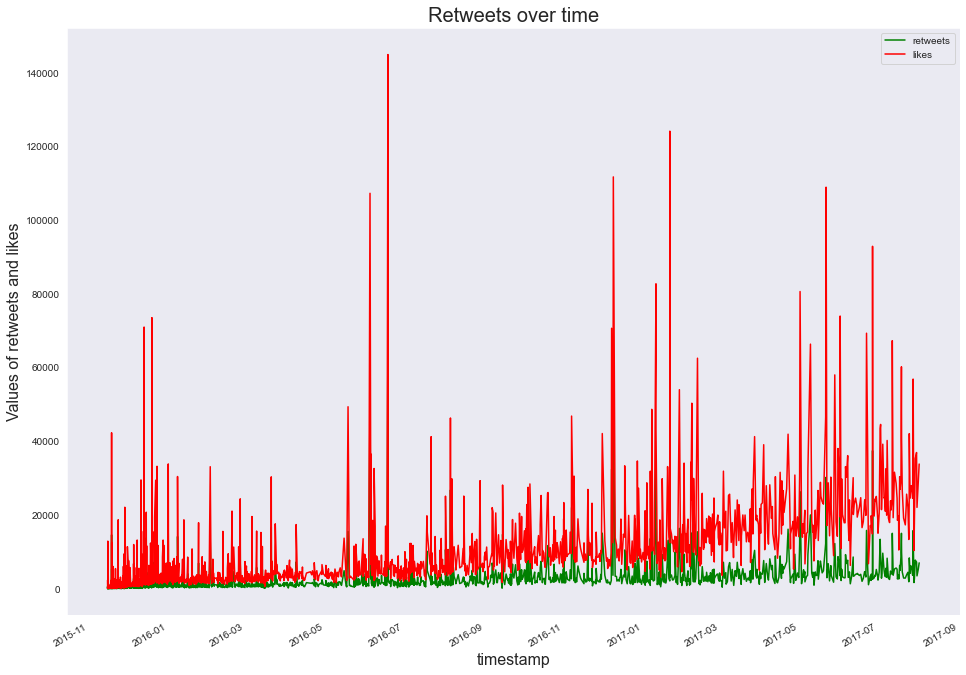

In [70]:
matpy.figure(figsize = (16, 12))
matpy.title("Retweets over time", fontsize = 20)

sb.set_style("dark")
matpy.xlabel("Timestamp", fontsize = 16)
matpy.ylabel("Values of retweets and likes", fontsize = 16)

df["retweets"].plot(color = "green")
df["likes"].plot(color = "red")
matpy.legend(loc = "upper right")
matpy.savefig("retweets_and_likes.png")
matpy.show()

In [71]:
highest_likes = data.sort_values("likes", ascending = False)[["likes", "ratings", 
                                                              "expanded_urls", "dog_stages"]]
highest_likes.head(10)

,likes,ratings,expanded_urls,dog_stages
768,144938,13.0,https://twitter.com/dog_rates/status/744234799...,doggo
305,124150,13.0,https://twitter.com/dog_rates/status/822872901...,puppo
396,111741,13.0,https://twitter.com/dog_rates/status/807106840...,NaN
107,108948,13.0,https://twitter.com/dog_rates/status/866450705...,pupper
803,107291,13.0,https://twitter.com/dog_rates/status/739238157...,doggo
58,92908,13.0,https://twitter.com/dog_rates/status/879415818...,NaN
329,82731,14.0,https://twitter.com/dog_rates/status/819004803...,doggo
134,80634,12.0,https://twitter.com/dog_rates/status/859196978...,NaN
92,73985,13.0,https://twitter.com/dog_rates/status/870374049...,NaN
1416,73549,12.0,https://twitter.com/dog_rates/status/678399652...,NaN


In [72]:
lowest_likes = data.sort_values("likes")[["likes", "ratings", "expanded_urls", "dog_stages"]]
lowest_likes.head(10)

,likes,ratings,expanded_urls,dog_stages
1968,66,11.0,https://twitter.com/dog_rates/status/666102155...,NaN
1980,89,5.0,https://twitter.com/dog_rates/status/666049248...,NaN
1948,90,9.0,https://twitter.com/dog_rates/status/666447344...,NaN
1956,93,7.0,https://twitter.com/dog_rates/status/666407126...,NaN
1971,93,6.0,https://twitter.com/dog_rates/status/666082916...,NaN
1975,99,8.0,https://twitter.com/dog_rates/status/666058600...,NaN
1982,100,9.0,https://twitter.com/dog_rates/status/666033412...,NaN
1966,100,10.0,https://twitter.com/dog_rates/status/666268910...,NaN
1949,106,7.0,https://twitter.com/dog_rates/status/666437273...,NaN
1954,107,10.0,https://twitter.com/dog_rates/status/666418789...,NaN


In [73]:
lowest_likes["expanded_urls"].values[0]

'https://twitter.com/dog_rates/status/666102155909144576/photo/1'

In [74]:
highest_likes["expanded_urls"].values[0]

'https://twitter.com/dog_rates/status/744234799360020481/video/1'

In [75]:
highest_retweets = data.sort_values("retweets", ascending = False)[["retweets", "ratings", "expanded_urls", 
                                                 "dog_stages"]]
highest_retweets.head(10)

,retweets,ratings,expanded_urls,dog_stages
768,70777,13.0,https://twitter.com/dog_rates/status/744234799...,doggo
803,52922,13.0,https://twitter.com/dog_rates/status/739238157...,doggo
396,51710,13.0,https://twitter.com/dog_rates/status/807106840...,NaN
305,39939,13.0,https://twitter.com/dog_rates/status/822872901...,puppo
58,37463,13.0,https://twitter.com/dog_rates/status/879415818...,NaN
329,34556,14.0,https://twitter.com/dog_rates/status/819004803...,doggo
398,32407,13.0,https://twitter.com/dog_rates/status/806629075...,NaN
107,30220,13.0,https://twitter.com/dog_rates/status/866450705...,pupper
1416,28616,12.0,https://twitter.com/dog_rates/status/678399652...,NaN
1474,27809,10.0,https://twitter.com/dog_rates/status/676219687...,NaN


In [76]:
highest_retweets["expanded_urls"].values[0]

'https://twitter.com/dog_rates/status/744234799360020481/video/1'

In [77]:
lowest_retweets = data.sort_values("retweets")[["retweets", "ratings", "expanded_urls", "dog_stages"]]
lowest_retweets.head(10)

,retweets,ratings,expanded_urls,dog_stages
1968,11,11.0,https://twitter.com/dog_rates/status/666102155...,NaN
1948,19,9.0,https://twitter.com/dog_rates/status/666447344...,NaN
1856,28,10.0,https://twitter.com/dog_rates/status/668291999...,NaN
1956,30,7.0,https://twitter.com/dog_rates/status/666407126...,NaN
1843,35,10.0,https://twitter.com/dog_rates/status/668620235...,NaN
1738,35,8.0,https://twitter.com/dog_rates/status/670676092...,NaN
1982,36,9.0,https://twitter.com/dog_rates/status/666033412...,NaN
1980,37,5.0,https://twitter.com/dog_rates/status/666049248...,NaN
1971,37,6.0,https://twitter.com/dog_rates/status/666082916...,NaN
1966,38,10.0,https://twitter.com/dog_rates/status/666268910...,NaN


In [78]:
lowest_retweets["expanded_urls"].values[0]

'https://twitter.com/dog_rates/status/666102155909144576/photo/1'

In [79]:
data.likes.corr(data.retweets)

0.9284022767934378

<a id='conclusions'></a>
## Conclusions

> As observed from above, possibly due to an increase in popularity or otherwise, there was a drastic increase in the amount of retweets over time and people tend to like over retweet. Also ratings withing the range `10 - 13` tended to have more likes

> Limitations of the analysis were:
> - Inability to get the dog stages of most dogs
> - Too many missing values